In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## Organize location and labels for relevant images

In [2]:
import pydicom
import imageio
import torch
from torch.utils.data import DataLoader
from torchvision import transforms, models
from tqdm import tqdm
import time
from matplotlib import pyplot as plt

# DATA AS DICOM

In [3]:
# def dcmtag2table(folder, list_of_tags):
#     """
#     Create a Pandas DataFrame with the <list_of_tags> DICOM tags
#     from the DICOM files in <folder>
    
#     Parameters:
#         folder (str): path for the folder to be recursively walked through looking for DICOM files
#         list_of_tags (list of strings): a list of DICOM tags with no whitespaces
        
#     Returns:
#         df (DataFrame): table of DICOM tags from the files in <folder>
#     """
    
#     list_of_tags = list_of_tags.copy()
#     items = []
#     table = []
#     filelist = []
#     print("Listing files...")
#     start = time.time()
#     for root, dirs, files in os.walk(folder, topdown=False):
#         for name in files:
#             filelist.append(os.path.join(root,name)) #Get list of files that are present in the folder
    
#     print("Time: " + str(time.time() - start))
#     print("Reading files...")
#     time.sleep(2)
#     for _f in tqdm(filelist):
#         try:
#             ds = pydicom.dcmread(_f, stop_before_pixels=True) #Try to read each of the files, if they aren't pydicom compatible, run <except>
#             items = [] # ^ The "stop_before_pixels" prevents the loading of the raw data, just metadata
#             items.append(_f)

#             for _tag in list_of_tags:
#                 if _tag in ds:
#                     items.append(ds.data_element(_tag).value) #Gets the values for the paremeters defined in <list_of_tags>
#                 else:
#                     items.append("Not found")

#             table.append((items)) #make a table of the tag values
#         except:
#             print("Skipping non-DICOM: " + _f)

    
#     list_of_tags.insert(0, "Filename") #add "Filename" to <list_of_tags>
#     test = list(map(list, zip(*table)))
#     dictone = {}

#     for i, _tag in enumerate (list_of_tags):
#         dictone[_tag] = test[i]

#     df = pd.DataFrame(dictone)
#     time.sleep(2)
#     print("Finished.")
#     return df
    

In [4]:
# tags = ['PhotometricInterpretation','BitsAllocated', 'SOPInstanceUID']
# dicom_tags_train =  dcmtag2table('../input/unifesp-x-ray-body-part-classifier/train', tags)

In [5]:
# def fill_targets(row):
#     bodyparts = {
#         0 :'Abdomen',
#         1 :'Ankle',
#         2 :'Cervical Spine',
#         3 :'Chest',
#         4 :'Clavicles',
#         5 :'Elbow',
#         6 :'Feet',
#         7 :'Finger',
#         8 :'Forearm',
#         9 :'Hand',
#         10 :'Hip',
#         11 :'Knee',
#         12 :'Lower Leg',
#         13 :'Lumbar Spine',
#         14 :'Others',
#         15 :'Pelvis',
#         16 :'Shoulder',
#         17 :'Sinus',
#         18 :'Skull',
#         19 :'Thigh' ,
#         20 :'Thoracic Spine',
#         21 :'Wrist',
#     }
    
#     row.Target = np.array(row.Target.split(" "))
#     for num in row.Target:
#         if num != '':
#             name = bodyparts[int(num)]
#             row.loc[name]=1
#     return row


# def image_prep(in_dir, lab_f=False):
#     """
#     Function to prepare the pandas table for use in the DataLoader
    
#     inputs:
#         in_dir [path]: location of the input directory containing your data
#         lab_f [path]: location of the csv containing the training labels, set as False if using with testing data
        
#     output:
#         img_tab [DataFrame]: Relevant information about the dataset being used
#     """
    
#     # Key for labels
#     bodyparts = {
#         0 :'Abdomen',
#         1 :'Ankle',
#         2 :'Cervical Spine',
#         3 :'Chest',
#         4 :'Clavicles',
#         5 :'Elbow',
#         6 :'Feet',
#         7 :'Finger',
#         8 :'Forearm',
#         9 :'Hand',
#         10 :'Hip',
#         11 :'Knee',
#         12 :'Lower Leg',
#         13 :'Lumbar Spine',
#         14 :'Others',
#         15 :'Pelvis',
#         16 :'Shoulder',
#         17 :'Sinus',
#         18 :'Skull',
#         19 :'Thigh' ,
#         20 :'Thoracic Spine',
#         21 :'Wrist',
#     }

#     reverse_train_labels = dict((v,k) for k,v in bodyparts.items())
    
#     # Relevant tags for inclusion in returned dataframe:
#     tags = ['PhotometricInterpretation','BitsAllocated', 'SOPInstanceUID']

#     dicom_tags =  dcmtag2table(in_dir, tags)
    
#     # Load in the training labels if present:
#     if lab_f:
#         lab_df = pd.read_csv(lab_f)
#         for key in bodyparts.keys():
#             lab_df[bodyparts[key]] = 0
            
#         dicom_labels = lab_df.apply(fill_targets, axis=1)

#         img_df = dicom_tags.merge(dicom_labels, on = 'SOPInstanceUID')
#     else:
#         img_df = dicom_tags
    
#     return img_df

# Create Dataset and DataLoader

In [6]:
## IMAGE DATASET FOR DICOM DATA

# class img_dataset(torch.utils.data.Dataset): #torch....Dataset characterizes a dataset for Pytorch
#     def __init__(self, in_dir, lab_f):
#         # Make function incorporating dcmtag2table and the steps required to organize data
#         self.data = image_prep(in_dir, lab_f)
        
#         self.preprocess = transforms.Compose([
#             transforms.Resize(256),
#             transforms.CenterCrop(224),
#             #transforms.ToTensor(),
#             transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229,0.234,0.225]),
#         ])
            
#     def __len__(self):
#         return len(self.data.Filename)
    
    
#     def __getitem__(self, idx):
#         # 'Generates one sample of data'
        
#         # This is where I get a filename and load it using: self.data.Filename[idx]
#         # Look at: https://pytorch.org/tutorials/beginner/basics/data_tutorial.html
#         f_path = self.data.Filename.iloc[idx]
        
#         dcm = pydicom.dcmread(f_path)
#         img = dcm.pixel_array
        
#         # randomize whether it is using Monochrome1 or Monochrome2
#         if np.random.choice([0,1]):
#             img = np.invert(img)
        
#         # TODO: Add some sort of normalization step aside from this?
#         img = img/img.max()
        
#         img = torch.from_numpy(img)
#         #print(img.repeat(3,1,1).size())
#         X = self.preprocess(img.repeat(3,1,1))
#         # For some reason, ResNet only takes doubles
#         X = X.double()
        
#         # Get the label information
#         Y = torch.tensor(self.data.iloc[idx,5:])
#         Y = Y.double()
        
#         # returns <input> and <target>, so the image and the vector of classification
        
#         return X, Y
    

In [7]:
# train_dataloader = DataLoader(
#     img_dataset('../input/unifesp-x-ray-body-part-classifier/train','../input/unifesp-x-ray-body-part-classifier/train.csv'),
#     batch_size = 64,
#     shuffle = True
# )

# Explore Images

In [8]:
# source = img_dataset('../input/unifesp-x-ray-body-part-classifier/train','../input/unifesp-x-ray-body-part-classifier/train.csv')

In [9]:
# for i in range(4):
#     X,Y = source.__getitem__(i)
#     print(X.size())

In [10]:
# X.unsqueeze(0)

In [11]:
# plt.imshow(X[2,:,:], cmap = 'gray')
# plt.show()

# DATA AS PNG

In [12]:
pd.read_csv('../input/xray-body-images-in-png-unifesp-competion/train_df.csv')

,SOPInstanceUID,Target,MultiImageType,ImageType,ImageType1,InstanceCreationDate,InstanceCreationTime,SOPClassUID,StudyDate,SeriesDate,...,WindowWidth,ImageType2,KVP,DistanceSourceToDetector,DistanceSourceToPatient,ExposureTime,XRayTubeCurrent,AcquisitionNumber,ImageType3,image_path
0,1.2.826.0.1.3680043.8.498.10025629581362719970...,0,1.0,ORIGINAL,PRIMARY,NaN,NaN,1.2.840.10008.5.1.4.1.1.1,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,./images/train/1.2.826.0.1.3680043.8.498.10025...
1,1.2.826.0.1.3680043.8.498.10036150326276641158...,15,1.0,ORIGINAL,PRIMARY,NaN,NaN,1.2.840.10008.5.1.4.1.1.1,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,./images/train/1.2.826.0.1.3680043.8.498.10036...
2,1.2.826.0.1.3680043.8.498.10038426859954986240...,12,1.0,ORIGINAL,PRIMARY,NaN,NaN,1.2.840.10008.5.1.4.1.1.1,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,./images/train/1.2.826.0.1.3680043.8.498.10038...
3,1.2.826.0.1.3680043.8.498.10050991192143676483...,14,NaN,NaN,NaN,NaN,NaN,1.2.840.10008.5.1.4.1.1.1,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,./images/train/1.2.826.0.1.3680043.8.498.10050...
4,1.2.826.0.1.3680043.8.498.10053309524595490852...,3,1.0,ORIGINAL,PRIMARY,NaN,NaN,1.2.840.10008.5.1.4.1.1.1,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,./images/train/1.2.826.0.1.3680043.8.498.10053...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1733,1.2.826.0.1.3680043.8.498.99711016467406172920...,14,1.0,ORIGINAL,PRIMARY,NaN,NaN,1.2.840.10008.5.1.4.1.1.1,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,./images/train/1.2.826.0.1.3680043.8.498.99711...
1734,1.2.826.0.1.3680043.8.498.99727280485333900933...,11,1.0,ORIGINAL,PRIMARY,NaN,NaN,1.2.840.10008.5.1.4.1.1.1,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,./images/train/1.2.826.0.1.3680043.8.498.99727...
1735,1.2.826.0.1.3680043.8.498.99935008698914755885...,3,1.0,ORIGINAL,PRIMARY,NaN,NaN,1.2.840.10008.5.1.4.1.1.1,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,./images/train/1.2.826.0.1.3680043.8.498.99935...
1736,1.2.826.0.1.3680043.8.498.99969671777553755311...,2,1.0,ORIGINAL,PRIMARY,NaN,NaN,1.2.840.10008.5.1.4.1.1.1,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,./images/train/1.2.826.0.1.3680043.8.498.99969...


In [13]:
imageio.imread('../input/xray-body-images-in-png-unifesp-competion/image_png.png').astype(float)

Array([[35., 36., 32., ..., 33., 34., 37.],
       [32., 33., 31., ..., 33., 32., 36.],
       [34., 34., 34., ..., 34., 34., 36.],
       ...,
       [34., 31., 33., ..., 32., 30., 35.],
       [33., 31., 34., ..., 32., 32., 35.],
       [35., 32., 34., ..., 34., 32., 34.]])

In [14]:
def pngtag2table(folder):
    """
    Create a Pandas DataFrame with the <list_of_tags> DICOM tags
    from the png files in <folder>
    
    Parameters:
        folder (str): path for the folder to be recursively walked through looking for DICOM files
        
    Returns:
        df (DataFrame): table of DICOM tags from the files in <folder>
    """
    
    IDlist = []
    filelist = []
    print("Listing files...")
    start = time.time()
    for root, dirs, files in os.walk(folder, topdown=False):
        for name in files:
            if '-c.png' in name:
                filelist.append(os.path.join(root,name)) #Get list of files that are present in the folder
                IDlist.append(name.split('-c.png')[0])
    
    df = pd.DataFrame({
        'Filename' : filelist,
         'SOPInstanceUID': IDlist})
    
    print("Finished.")
    return df
    

In [15]:
# image_prep('../input/xray-body-images-in-png-unifesp-competion/images/train/','../input/xray-body-images-in-png-unifesp-competion/train_df.csv').head(10)

In [16]:
def fill_targets(row):
    bodyparts = {
        0 :'Abdomen',
        1 :'Ankle',
        2 :'Cervical Spine',
        3 :'Chest',
        4 :'Clavicles',
        5 :'Elbow',
        6 :'Feet',
        7 :'Finger',
        8 :'Forearm',
        9 :'Hand',
        10 :'Hip',
        11 :'Knee',
        12 :'Lower Leg',
        13 :'Lumbar Spine',
        14 :'Others',
        15 :'Pelvis',
        16 :'Shoulder',
        17 :'Sinus',
        18 :'Skull',
        19 :'Thigh' ,
        20 :'Thoracic Spine',
        21 :'Wrist',
    }
    
    row.Target = np.array(row.Target.split(" "))
    for num in row.Target:
        if num != '':
            name = bodyparts[int(num)]
            row.loc[name]=1
    return row


def image_prep(in_dir, lab_f=False):
    """
    Function to prepare the pandas table for use in the DataLoader
    
    inputs:
        in_dir [path]: location of the input directory containing your data
        lab_f [path]: location of the csv containing the training labels, set as False if using with testing data
        
    output:
        img_tab [DataFrame]: Relevant information about the dataset being used
    """
    
    # Key for labels
    bodyparts = {
        0 :'Abdomen',
        1 :'Ankle',
        2 :'Cervical Spine',
        3 :'Chest',
        4 :'Clavicles',
        5 :'Elbow',
        6 :'Feet',
        7 :'Finger',
        8 :'Forearm',
        9 :'Hand',
        10 :'Hip',
        11 :'Knee',
        12 :'Lower Leg',
        13 :'Lumbar Spine',
        14 :'Others',
        15 :'Pelvis',
        16 :'Shoulder',
        17 :'Sinus',
        18 :'Skull',
        19 :'Thigh' ,
        20 :'Thoracic Spine',
        21 :'Wrist',
    }

    reverse_train_labels = dict((v,k) for k,v in bodyparts.items())

    dicom_tags =  pngtag2table(in_dir)
    
    # Load in the training labels if present:
    if lab_f:
        lab_df = pd.read_csv(lab_f)[['SOPInstanceUID','Target']]
        for key in bodyparts.keys():
            lab_df[bodyparts[key]] = 0
            
        dicom_labels = lab_df.apply(fill_targets, axis=1)

        img_df = dicom_tags.merge(dicom_labels, on = 'SOPInstanceUID')
    else:
        img_df = dicom_tags
    
    return img_df

In [17]:
## IMAGE DATASET FOR PNG DATA

class img_dataset(torch.utils.data.Dataset): #torch....Dataset characterizes a dataset for Pytorch
    def __init__(self, in_dir, lab_f):
        # Make function incorporating dcmtag2table and the steps required to organize data
        self.data = image_prep(in_dir, lab_f)
        
        self.preprocess = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            #transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229,0.234,0.225]),
        ])
            
    def __len__(self):
        return len(self.data.Filename)
    
    
    def __getitem__(self, idx):
        # 'Generates one sample of data'
        
        # This is where I get a filename and load it using: self.data.Filename[idx]
        # Look at: https://pytorch.org/tutorials/beginner/basics/data_tutorial.html
        f_path = self.data.Filename.iloc[idx]
        
        img = imageio.imread(f_path).astype('double')
        
        # randomize whether it is using Monochrome1 or Monochrome2
        if np.random.choice([0,1]):
            img = 255-img
        
        # TODO: Add some sort of normalization step aside from this?
        img = img/img.max()
        
        img = torch.from_numpy(img)
        #print(img.repeat(3,1,1).size())
        X = self.preprocess(img.repeat(3,1,1))
        # For some reason, ResNet only takes doubles
        X = X.double()
        
        # Get the label information
        Y = torch.tensor(self.data.iloc[idx,3:])
        Y = Y.double()
        
        # returns <input> and <target>, so the image and the vector of classification
        
        return X, Y

In [18]:
from torch.utils.data import DataLoader

# train_dataloader = DataLoader(
#     img_dataset('../input/xray-body-images-in-png-unifesp-competion/images/train/','../input/xray-body-images-in-png-unifesp-competion/train_df.csv'),
#     batch_size = 64,
#     shuffle = True
# )

# Define the model
Try a few different network models in order to figure out what works best

In [19]:
# Make simple ResNet

class Model_v1(torch.nn.Module):
    def __init__(self):
        super().__init__()
        # Define the different layers
        resnet = models.resnext50_32x4d(pretrained=True)
        resnet.fc = torch.nn.Sequential(
            torch.nn.Dropout(p=0.2),
            torch.nn.Linear(in_features=resnet.fc.in_features, out_features=22)
        )
        self.base_model = resnet
        self.sigm = torch.nn.Sigmoid()
    
    def forward(self, x):
        # Forward pass information
        return self.sigm(self.base_model(x))

# For some reason I need to set the weights of ResNet to double, even though they are originally float32
model = Model_v1().double()

Downloading: "https://download.pytorch.org/models/resnext50_32x4d-7cdf4587.pth" to /root/.cache/torch/hub/checkpoints/resnext50_32x4d-7cdf4587.pth


  0%|          | 0.00/95.8M [00:00<?, ?B/s]

In [20]:
# Make custom model:
# Less time consuming than the ResNet

# class Model_v2(torch.nn.Module):
#     def __init__(self):
#         super().__init__()
#         pass
    
    
#     def forward(self, x):
#         # Returns a vector containing either 0 or 1 for each image type
#         return self.sigm(self.base_model(x))
        
        

In [21]:
# for i in model.parameters():
#     print(i.dtype)

In [22]:
# image, label = [ x[0] for x in iter(train_dataloader).next() ]
# image.double().dtype

# Define the optimizer

In [23]:
criterion = torch.nn.BCELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Performance metrics

In [24]:
from sklearn.metrics import precision_score, recall_score, f1_score

def calculate_metrics(pred, target, threshold=0.5):
    pred = np.array(pred > threshold, dtype=float)
    return {'micro/precision': precision_score(y_true=target, y_pred=pred, average='micro'),
            'micro/recall': recall_score(y_true=target, y_pred=pred, average='micro'),
            'micro/f1': f1_score(y_true=target, y_pred=pred, average='micro'),
            'macro/precision': precision_score(y_true=target, y_pred=pred, average='macro'),
            'macro/recall': recall_score(y_true=target, y_pred=pred, average='macro'),
            'macro/f1': f1_score(y_true=target, y_pred=pred, average='macro'),
            'samples/precision': precision_score(y_true=target, y_pred=pred, average='samples'),
            'samples/recall': recall_score(y_true=target, y_pred=pred, average='samples'),
            'samples/f1': f1_score(y_true=target, y_pred=pred, average='samples'),
            }

# Train the Network

In [25]:
# Split training data into training and validating subsets
# full_dataset = img_dataset('../input/xray-body-images-in-png-unifesp-competion/images/train/','../input/xray-body-images-in-png-unifesp-competion/train_df.csv')
# train_size = int(0.9 * len(full_dataset))
# valid_size = len(full_dataset) - train_size
# train_dataset, valid_dataset = torch.utils.data.random_split(full_dataset, [train_size, valid_size])

train_dataloader = DataLoader(
    img_dataset('../input/xray-body-images-in-png-unifesp-competion/images/train/','../input/xray-body-images-in-png-unifesp-competion/train_df.csv'),
    batch_size = 60,
    shuffle = True
)

# valid_dataloader = DataLoader(
#     valid_dataset,
#     batch_size = 30,
#     shuffle = True
# )

Listing files...
Finished.


In [26]:
epoch = 0
max_epoch_number = 14
iteration = 0
test_freq = 60 #how often to print status reports

while True:
    batch_losses = []
    for imgs, targets in tqdm(train_dataloader):
        #imgs, targets = imgs.to(device), targets.to(device)
        
        optimizer.zero_grad()
        
        model_result = model(imgs)
        loss = criterion(model_result, targets)#.type(torch.float))
        
        batch_loss_value = loss.item()
        loss.backward()
        optimizer.step()
        
        batch_losses.append(batch_loss_value)
        
#         if iteration % test_freq == 0:
#             model.eval()
#             with torch.no_grad():
#                 model_result = []
#                 targets = []
#                 for imgs, batch_targets in valid_dataloader:
# #                     imgs = imgs.to(device)
#                     model_batch_result = model(imgs)
#                     model_result.extend(model_batch_result.numpy())
#                     targets.extend(batch_targets.numpy())

#             result = calculate_metrics(np.array(model_result), np.array(targets))
#             print("epoch:{:2d} iter:{:3d} test: "
#                   "micro f1: {:.3f} "
#                   "macro f1: {:.3f} "
#                   "samples f1: {:.3f}".format(epoch, iteration,
#                                               result['micro/f1'],
#                                               result['macro/f1'],
#                                               result['samples/f1']))

#             model.train()
#         iteration += 1

    loss_value = np.mean(batch_losses)
    print("epoch:{:2d} iter:{:3d} train: loss:{:.3f}".format(epoch, iteration, loss_value))
#     if epoch % save_freq == 0:
#         checkpoint_save(model, save_path, epoch)
    epoch += 1
    if max_epoch_number < epoch:
        break

100%|██████████| 29/29 [24:31<00:00, 50.75s/it]


epoch: 0 iter:  0 train: loss:0.106


100%|██████████| 29/29 [24:05<00:00, 49.83s/it]


epoch: 1 iter:  0 train: loss:0.047


100%|██████████| 29/29 [23:54<00:00, 49.48s/it]


epoch: 2 iter:  0 train: loss:0.037


100%|██████████| 29/29 [23:46<00:00, 49.20s/it]


epoch: 3 iter:  0 train: loss:0.031


100%|██████████| 29/29 [23:32<00:00, 48.72s/it]


epoch: 4 iter:  0 train: loss:0.027


100%|██████████| 29/29 [23:28<00:00, 48.56s/it]


epoch: 5 iter:  0 train: loss:0.024


100%|██████████| 29/29 [23:32<00:00, 48.71s/it]


epoch: 6 iter:  0 train: loss:0.024


100%|██████████| 29/29 [23:33<00:00, 48.73s/it]


epoch: 7 iter:  0 train: loss:0.021


100%|██████████| 29/29 [23:29<00:00, 48.62s/it]


epoch: 8 iter:  0 train: loss:0.016


100%|██████████| 29/29 [23:34<00:00, 48.76s/it]


epoch: 9 iter:  0 train: loss:0.015


100%|██████████| 29/29 [23:31<00:00, 48.66s/it]


epoch:10 iter:  0 train: loss:0.012


100%|██████████| 29/29 [23:34<00:00, 48.76s/it]


epoch:11 iter:  0 train: loss:0.014


100%|██████████| 29/29 [23:34<00:00, 48.78s/it]


epoch:12 iter:  0 train: loss:0.011


100%|██████████| 29/29 [23:23<00:00, 48.39s/it]


epoch:13 iter:  0 train: loss:0.008


100%|██████████| 29/29 [23:24<00:00, 48.42s/it]

epoch:14 iter:  0 train: loss:0.005


# Test the Network

In [27]:
# Load test dataset
test_dataset = img_dataset('../input/xray-body-images-in-png-unifesp-competion/images/test/','../input/xray-body-images-in-png-unifesp-competion/test_df.csv')

# Make dataloader for test data, no reason to make the batches large if it's not being used for training
test_dataloader = DataLoader(
    test_dataset,
    batch_size = 30,
    shuffle = False
)

Listing files...
Finished.


In [28]:
model.eval()
with torch.no_grad():
    model_result = []
    for imgs, batch_targets in test_dataloader:
        model_batch_result = model(imgs)
        model_result.extend(model_batch_result.numpy())

# Convert predictions into binary
predicts = np.array(np.array(model_result)>0.5, dtype=float)

In [29]:
# Convert predictions into table and save as csv file

#q = image_prep('../input/xray-body-images-in-png-unifesp-competion/images/test/')

tags = []
for idx, pred in enumerate(predicts):
    _ = np.where(pred==1)[0]
    if _.size == 0:
        # If there is not prediction above 50%, then just take the highest perdiction
        _ = np.array(np.array(model_result[idx])==np.array(model_result[idx]).max(), dtype = float)
        tags.append(np.where(_==1)[0])
    else:
        tags.append(_)
        
results = image_prep('../input/xray-body-images-in-png-unifesp-competion/images/test/')

results['Target'] = tags


Listing files...
Finished.


In [30]:
tags

[array([3]),
 array([13, 20]),
 array([3]),
 array([14]),
 array([9]),
 array([14]),
 array([2]),
 array([3]),
 array([3]),
 array([0]),
 array([3]),
 array([3]),
 array([3]),
 array([3]),
 array([3]),
 array([3]),
 array([6]),
 array([0]),
 array([3]),
 array([6]),
 array([0]),
 array([5]),
 array([3]),
 array([3]),
 array([3]),
 array([3]),
 array([3]),
 array([14]),
 array([0]),
 array([3]),
 array([3]),
 array([3]),
 array([1]),
 array([13, 20]),
 array([3]),
 array([3]),
 array([3]),
 array([0]),
 array([3]),
 array([3]),
 array([0]),
 array([3]),
 array([14]),
 array([3]),
 array([3]),
 array([3]),
 array([3]),
 array([3]),
 array([14]),
 array([13, 20]),
 array([3]),
 array([3]),
 array([2]),
 array([14]),
 array([6]),
 array([3]),
 array([17]),
 array([21]),
 array([15]),
 array([3]),
 array([6]),
 array([3]),
 array([14]),
 array([3]),
 array([13, 20]),
 array([7]),
 array([3]),
 array([7]),
 array([15]),
 array([14]),
 array([3]),
 array([14]),
 array([13, 20]),
 array([3]),


In [31]:
results['Target'] = results['Target'].astype(str).str.strip('[|]')

In [32]:
submission_df = results[['SOPInstanceUID','Target']]
submission_df.to_csv('submission.csv',header=True, index=False)

In [33]:
submission_df.head(10)

,SOPInstanceUID,Target
0,1.2.826.0.1.3680043.8.498.26320830403996890405...,3
1,1.2.826.0.1.3680043.8.498.68937905807253381993...,13 20
2,1.2.826.0.1.3680043.8.498.66266093725587193363...,3
3,1.2.826.0.1.3680043.8.498.50797364402056824587...,14
4,1.2.826.0.1.3680043.8.498.78821712082546284288...,9
5,1.2.826.0.1.3680043.8.498.44852578201460782452...,14
6,1.2.826.0.1.3680043.8.498.49185343954351360348...,2
7,1.2.826.0.1.3680043.8.498.45445784849171253069...,3
8,1.2.826.0.1.3680043.8.498.41921603666826538216...,3
9,1.2.826.0.1.3680043.8.498.58485830501675594263...,0


In [34]:
pd.read_csv('submission.csv')
# pd.read_csv('../input/unifesp-x-ray-body-part-classifier/train.csv')

,SOPInstanceUID,Target
0,1.2.826.0.1.3680043.8.498.26320830403996890405...,3
1,1.2.826.0.1.3680043.8.498.68937905807253381993...,13 20
2,1.2.826.0.1.3680043.8.498.66266093725587193363...,3
3,1.2.826.0.1.3680043.8.498.50797364402056824587...,14
4,1.2.826.0.1.3680043.8.498.78821712082546284288...,9
...,...,...
738,1.2.826.0.1.3680043.8.498.78086026280182392419...,3
739,1.2.826.0.1.3680043.8.498.13038526348243066795...,3
740,1.2.826.0.1.3680043.8.498.90407372373988229364...,11
741,1.2.826.0.1.3680043.8.498.13711169384777081133...,3


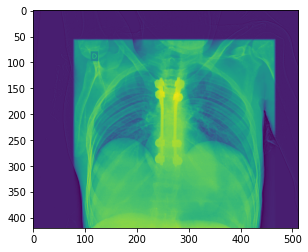

In [35]:
img = imageio.imread('../input/xray-body-images-in-png-unifesp-competion/images/test/'+submission_df.SOPInstanceUID.iloc[741]+'-c.png').astype('double')
plt.imshow(img)